In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [137]:
def train_test_split(X, Y):
    """Split data into training and testing partitions"""
    n = len(Y)

    indices = np.arange(0, n)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]
    
    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]

    return X_train, Y_train, X_test, Y_test

def normalize(X_train, X_test):
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [138]:
def run(X, Y, models=[], niter=50):
    results = defaultdict(list)
    for i in range(niter):
        runner = Predictor(X, Y) #initalize new predictor object - data will be resplit to train/test
        for model_type in models:
            model_run_results = runner.run_model(model_type)
            for model_name, mse in model_run_results.items():
                results[model_name].append(mse)
    return results

class Predictor:
    def __init__(self, X, Y):
        X_train, Y_train, X_test, Y_test = train_test_split(X, Y)
        X_train, X_test = normalize(X_train, X_test)
        self.X_train = X_train
        self.Y_train = Y_train.to_numpy()
        self.X_test = X_test
        self.Y_test = Y_test.to_numpy()

    def run_model(self, model_type):
        results = {}
        fit_method = getattr(self, f"fit_{model_type}")
        models = fit_method()
        for model_name, model in models.items():
            if model_name == "lasso_model_refit":
                mse = self.mse(model, X_train.iloc[:, self.lasso_refit_nonzero_indices], Y_train)
            else:
                mse = self.mse(model, self.X_test, self.Y_test)
            results[model_name] = mse
        return results
        
    def mse(self, model, X_test, Y_test):
        return mean_squared_error(Y_test, model.predict(X_test))
    
    def fit_linear(self):
        model = lm().fit(self.X_train, self.Y_train)
        return {"linear_model": model}

    def fit_ridge(self):
        ridge_alphas = np.logspace(-10, 1, 100)
        ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                          scoring = 'neg_mean_squared_error')
        ridgecv.fit(self.X_train, self.Y_train)
        ridgecv.alpha_
        
        ridge_model = Ridge(alpha = ridgecv.alpha_)
        ridge_model.fit(self.X_train, self.Y_train)

        return {"ridge_model": ridge_model}

    def fit_lasso(self):
        lasso_alphas = np.logspace(-10, 1, 100)
        lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
        lassocv.fit(X_train, Y_train)
        lassocv.alpha_
        
        mean_mse = np.mean(lassocv.mse_path_, axis=1)
        std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 
        
        cv_alphas = lassocv.alphas_
        min_idx = np.argmin(mean_mse)
        
        alpha_min = cv_alphas[min_idx]
        
        threshold = mean_mse[min_idx] + std_mse[min_idx]
        alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])
        
        alpha_min, alpha_1se  #alpha_min = lassocv.alpha_

        # lasso model with min alpha
        lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
        lasso_model_min.fit(X_train, Y_train)

        # lasso model with 1se alpha
        lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
        lasso_model_1se.fit(X_train, Y_train)

        # lasso model refit with 1se
        self.lasso_refit_nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
        lm_refit = lm()
        lm_refit.fit(X_train.iloc[:, self.lasso_refit_nonzero_indices], Y_train)

        return {"lasso_model_1se": lasso_model_1se, "lasso_model_min": lasso_model_min, "lasso_model_refit": lm_refit}

    def fit_pcr(self):
        pcr = PCR()
        pcr.fit(self.X_train, self.Y_train)
        return {"pcr": pcr}

class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] +=  np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)


## Simulation Study Case 1

In [ ]:
url = "Coding2_Data1.csv"
myData = pd.read_csv(url)
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

results = run(X, Y, models = ["linear", "ridge", "lasso", "pcr"], niter=50)

/Users/Olivia.Dalglish/.local/share/virtualenvs/psl-lPdEi-7b/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/Users/Olivia.Dalglish/.local/share/virtualenvs/psl-lPdEi-7b/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/Users/Olivia.Dalglish/.local/share/virtualenvs/psl-lPdEi-7b/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/Users/Olivia.Dalglish/.local/share/virtualenvs/psl-lPdEi-7b/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/Users/Olivia.Dalglish/.local/share/virtualenvs/psl-lPdEi-7b/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X do

In [ ]:
print(pd.DataFrame(results).describe().to_dict())

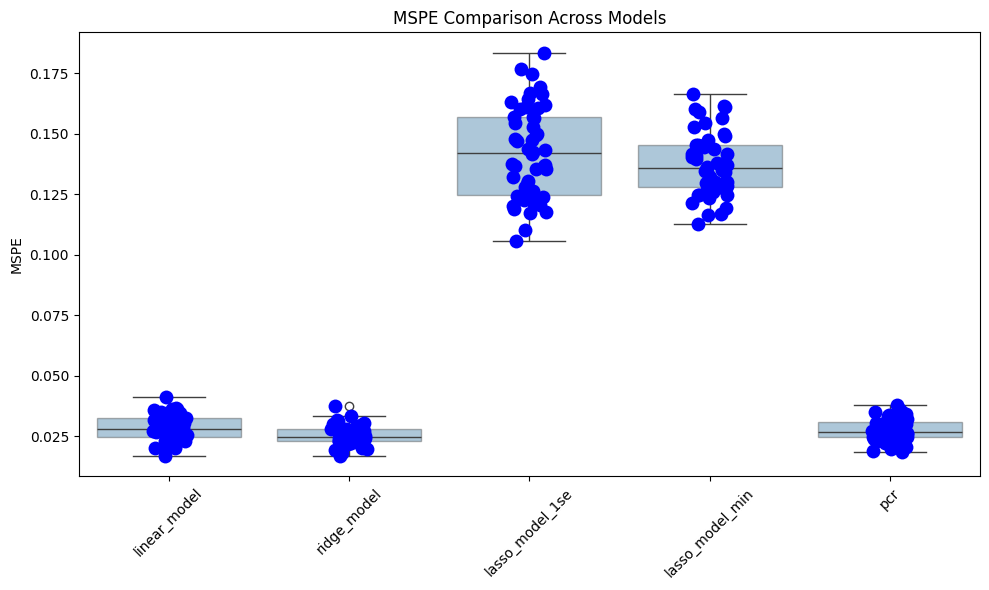

In [135]:
data_list = [(model, mspe) for model, mspe_values in results.items() for mspe in mspe_values]
models, mspe_values = zip(*data_list)

plt.figure(figsize=(10, 6))

sns.stripplot(x=models, y=mspe_values, jitter=True, color="blue", size=10)

sns.boxplot(x=models, y=mspe_values, boxprops={'alpha': 0.4})
plt.title('MSPE Comparison Across Models')
plt.ylabel('MSPE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Discussion

 Which procedure or procedures yield the best performance in terms of MSPE?
– Conversely, which procedure or procedures show the poorest performance?
– In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better
MSPE?
– Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?
– Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find
the performance of the Full model to be comparable to, or divergent from, the best-performing
procedure among the other five?

## Simulation Study Case 2

In [ ]:
url = "Coding2_Data2.csv"
myData = pd.read_csv(url)
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

results = run(X, Y, models = ["ridge", "lasso", "pcr"], niter=50)

In [ ]:
data_list = [(model, mspe) for model, mspe_values in results.items() for mspe in mspe_values]
models, mspe_values = zip(*data_list)

plt.figure(figsize=(10, 6))

sns.stripplot(x=models, y=mspe_values, jitter=True, color="blue", size=10)

sns.boxplot(x=models, y=mspe_values, boxprops={'alpha': 0.4})
plt.title('MSPE Comparison Across Models')
plt.ylabel('MSPE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Discussion

Which procedure or procedures yield the best performance in terms of MSPE?
– Conversely, which procedure or procedures show the poorest performance?
– Have you observed any procedure or procedures that performed well in Case I but exhibited poorer
performance in Case II, or vice versa? If so, please offer an explanation.
– Given that Coding2_Data2.csv includes all features found in Coding2_Data1.csv, one might
anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case
I. Do your simulation results corroborate this expectation? If not, please offer an explanation.